# U-Net Segmentation

In [1]:
import sys, os
sys.path.append('../')

import tensorflow as tf 

from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss, soft_dice_loss
from MRIsegm.models import unet
from MRIsegm.methods import create_segmentation_generator, show_dataset, plot_history, show_prediction

## Constants

In [2]:
SEED = 666
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALIDATION = 4

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 444
NUM_VALIDATION = 42

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_VALIDATION = NUM_VALIDATION // BATCH_SIZE_VALIDATION

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')


## Generators

In [3]:
data_gen_args_img = data_gen_args_mask = dict(rescale=1./255, rotation_range=5,horizontal_flip=True)
val_data_gen_args_img = val_data_gen_args_mask = dict(rescale=1./255)

In [4]:
train_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, BATCH_SIZE_VALIDATION, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask)

Found 444 images belonging to 1 classes.
Found 444 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


### Show trainig data

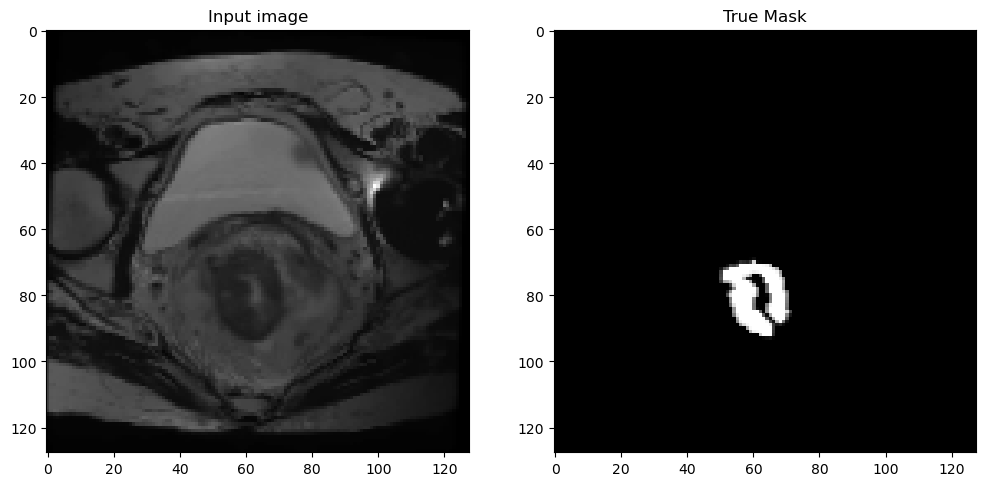

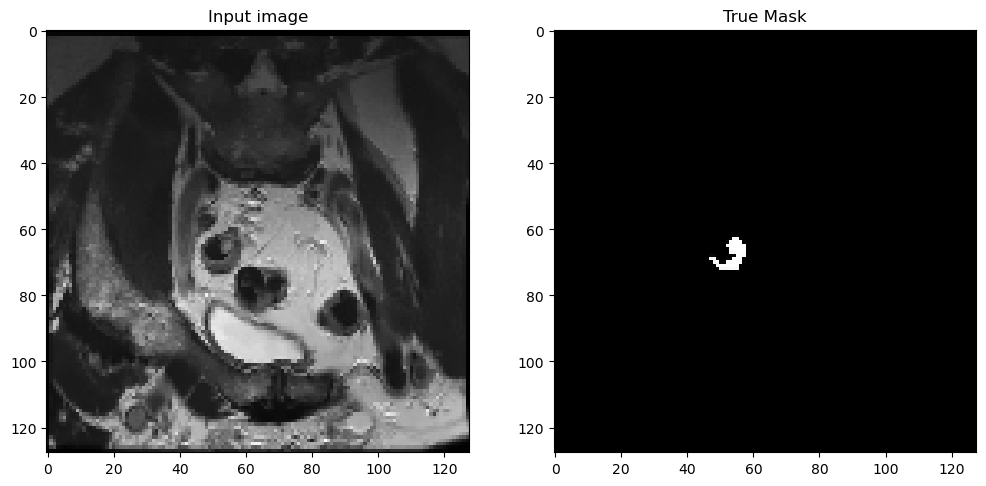

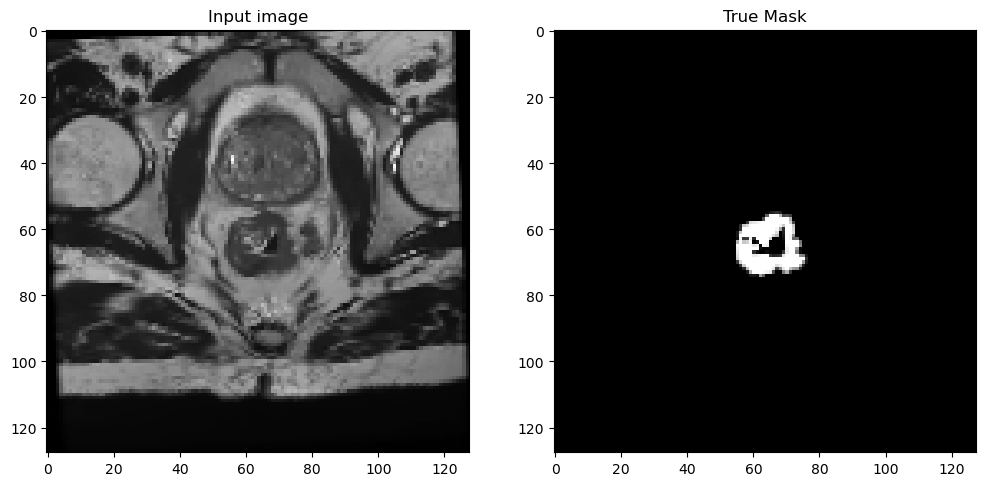

In [5]:
show_dataset(train_generator, 3) # training

### Show validation data

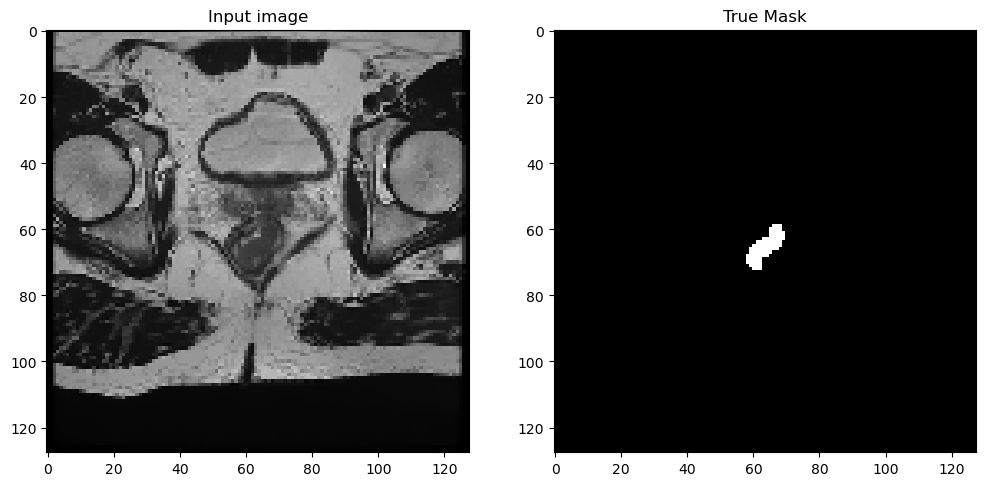

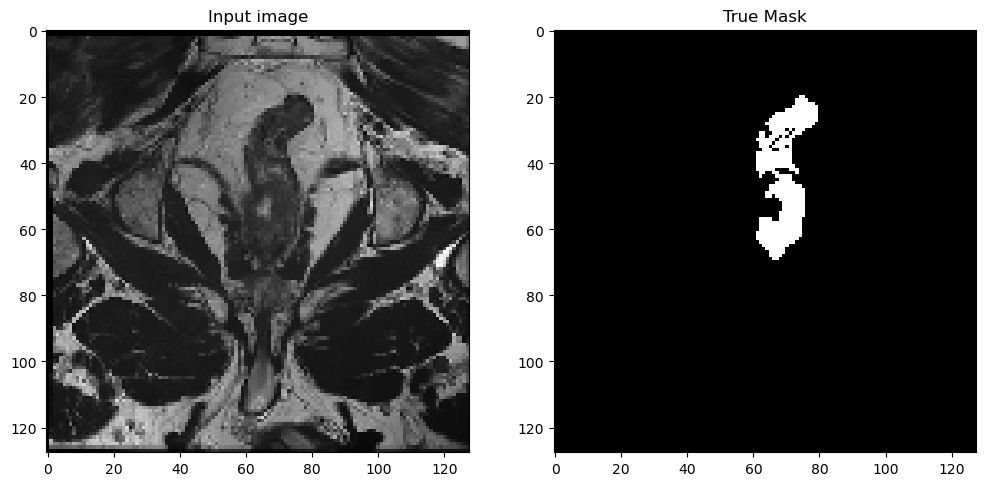

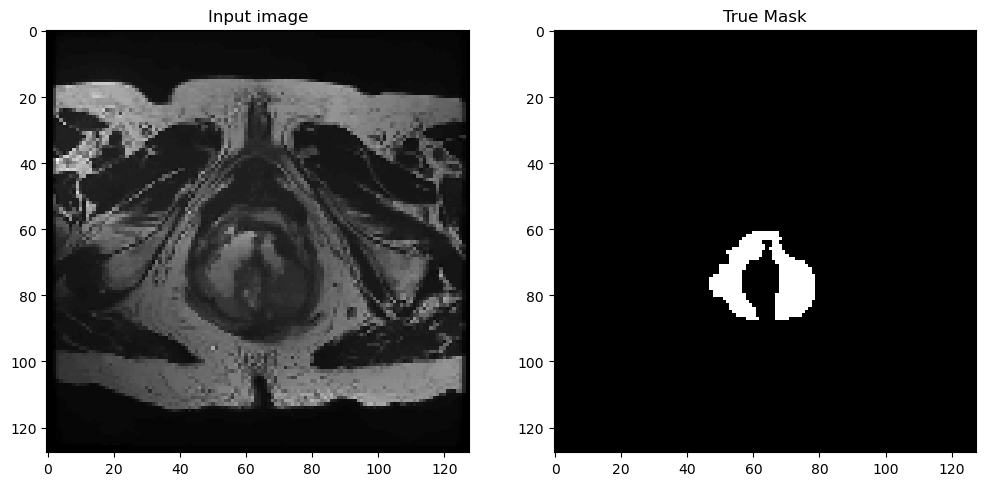

In [6]:
show_dataset(validation_generator, 3) # validation

## U-Net Model

In [7]:
model = unet(IMAGE_HEIGHT, IMAGE_WIDTH)

optimizer = 'adam'
loss = soft_dice_loss
metrics = [  dice_coef ]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

In [8]:
model_name = model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_eps={NUM_OF_EPOCHS}' 

if type(optimizer) == str: 
    model_name = model_name + f'_opt={optimizer}' 
else:
    model_name = model_name + f'_opt={optimizer._name}'

if type(loss) == str: 
    model_name = model_name + f'_loss={loss}' 
else:
    model_name = model_name + f'_loss={loss.__name__}'

print('model name: ', model_name)

model name:  UNET-L4-F64_128_128_eps=100_opt=adam_loss=soft_dice_loss


In [9]:
# optional: logs_dir = '../data/models/logs/model_name'
csv_dir = '../data/CSV/'

callbacks = [
                  tf.keras.callbacks.ModelCheckpoint('../data/models/checkpoints/' + model_name + '_checkpoint' + '.h5', save_best_only=True),
                  tf.keras.callbacks.CSVLogger( csv_dir + model_name + '.csv', separator=',', append=False)
                  # optional : tf.keras.callbacks.EarlyStopping(patience=11, monitor='val_loss', mode='min')
                  # optional: tf.keras.callbacks.TensorBoard(log_dir=logs_dir)
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=validation_generator, 
            validation_steps=EPOCH_STEP_VALIDATION,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)

Epoch 1/100
111/111 [==============================] - 89s 793ms/step - loss: 0.9093 - dice_coef: 0.0308 - val_loss: 0.7513 - val_dice_coef: 0.1179
Epoch 2/100
111/111 [==============================] - 88s 797ms/step - loss: 0.7704 - dice_coef: 0.1039 - val_loss: 0.5790 - val_dice_coef: 0.2722
Epoch 3/100
111/111 [==============================] - 90s 812ms/step - loss: 0.7022 - dice_coef: 0.1628 - val_loss: 0.6195 - val_dice_coef: 0.2983
Epoch 4/100
111/111 [==============================] - 89s 804ms/step - loss: 0.6192 - dice_coef: 0.2434 - val_loss: 0.5900 - val_dice_coef: 0.3340
Epoch 5/100
111/111 [==============================] - 89s 803ms/step - loss: 0.5990 - dice_coef: 0.2660 - val_loss: 0.5511 - val_dice_coef: 0.3325
Epoch 6/100
111/111 [==============================] - 89s 802ms/step - loss: 0.5280 - dice_coef: 0.3113 - val_loss: 0.5112 - val_dice_coef: 0.3594
Epoch 7/100
111/111 [==============================] - 89s 798ms/step - loss: 0.5172 - dice_coef: 0.3329 - val_l

In [10]:
model.save('../data/models/' + model_name + '.h5')

In [11]:
# optional: %load_ext tensorboard

# optional: !tensorboard --logdir log_dir

In [12]:
print("Evaluating on validation data")
result = model.evaluate(validation_generator, batch_size=BATCH_SIZE_VALIDATION, steps=EPOCH_STEP_VALIDATION, return_dict=True)
print(result)

Evaluating on validation data
10/10 [==============================] - 1s 124ms/step - loss: 0.2487 - dice_coef: 0.6854
{'loss': 0.2486959993839264, 'dice_coef': 0.6854077577590942}


## Plots

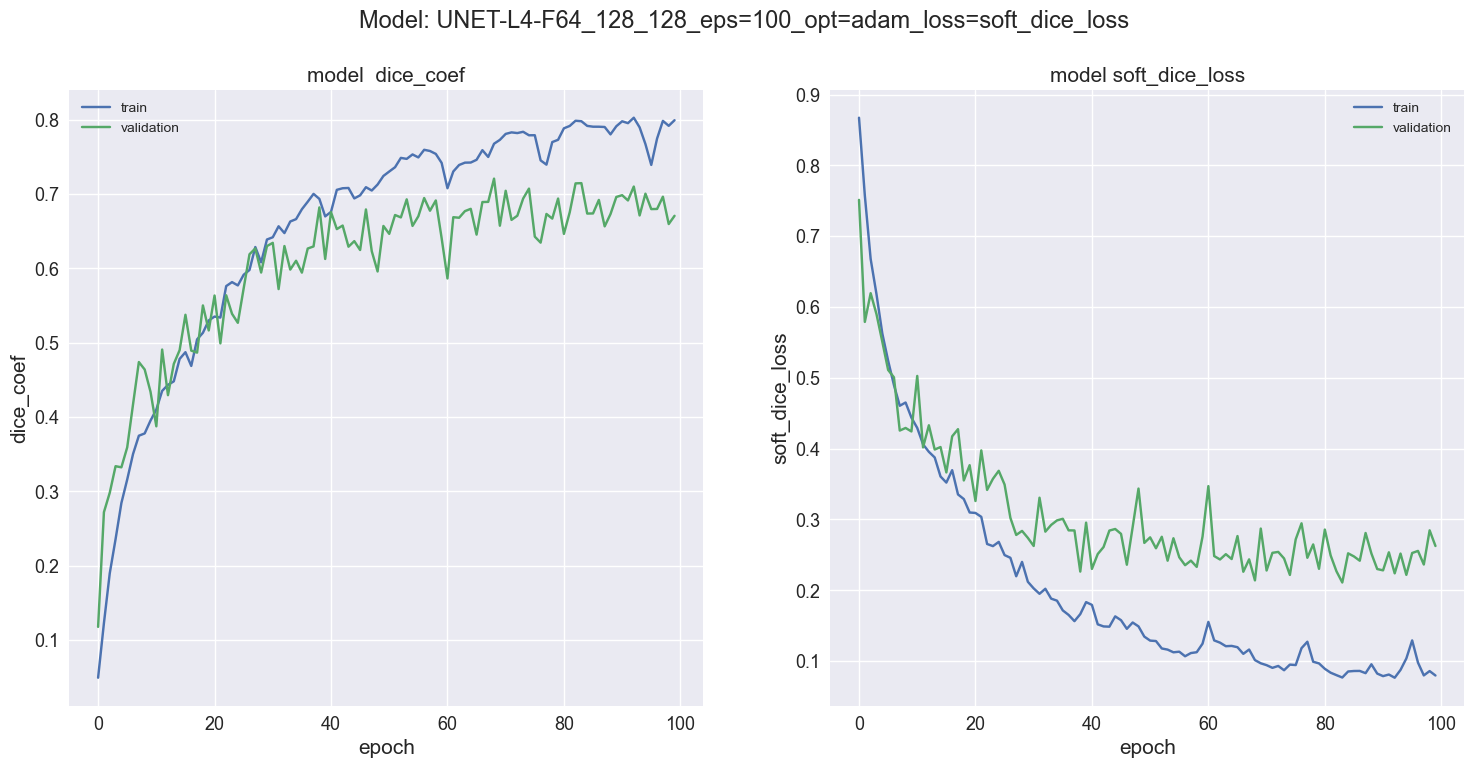

In [13]:
plot_history(model_name, history, metrics, loss, custom_loss=True, custom_metrics=True, labelsize=13, path='../data/plots/' + model_name)

## Predictions

### Training images prediction

Found 444 images belonging to 1 classes.
Found 444 images belonging to 1 classes.


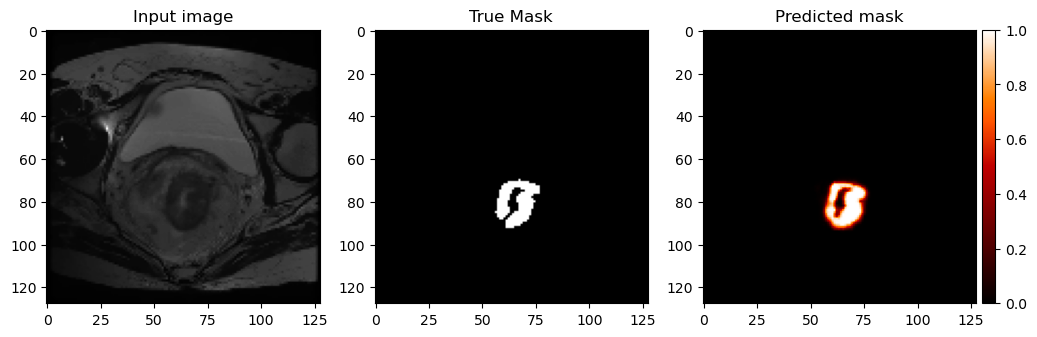

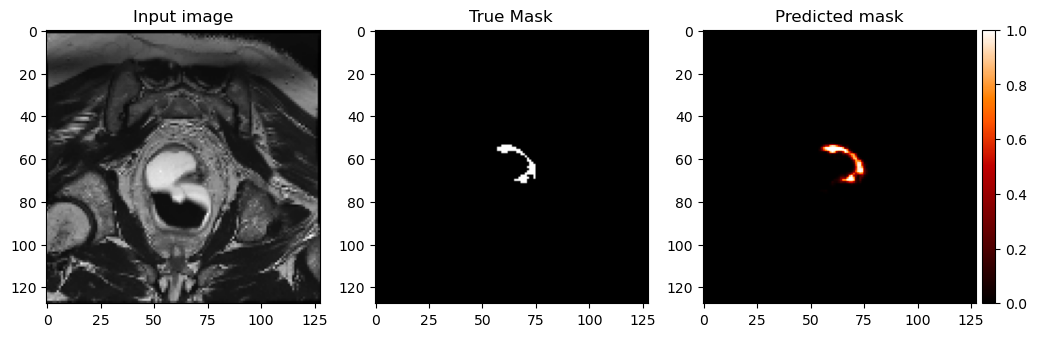

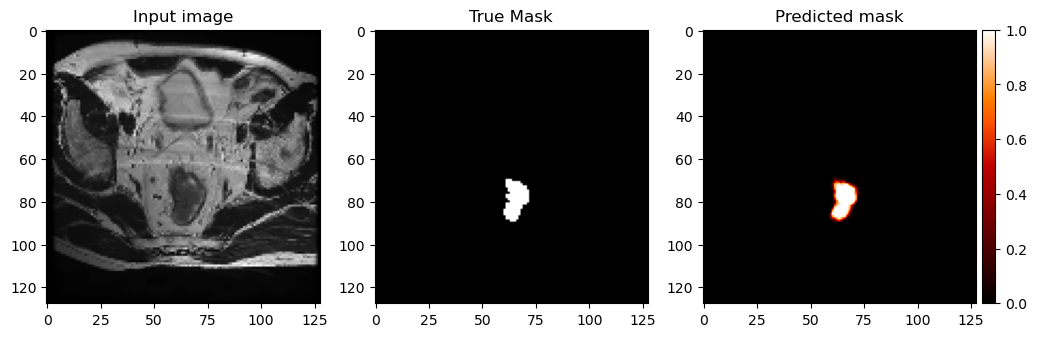

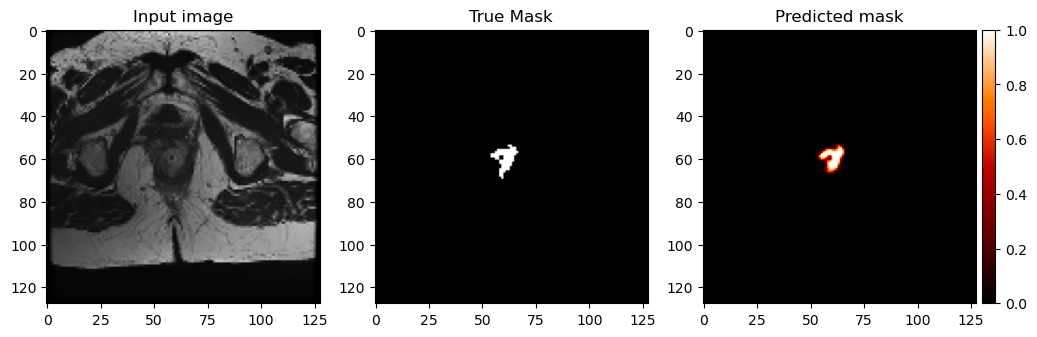

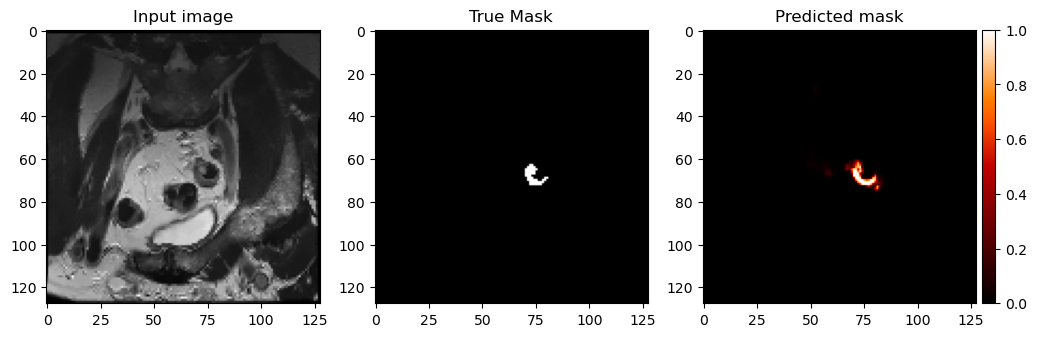

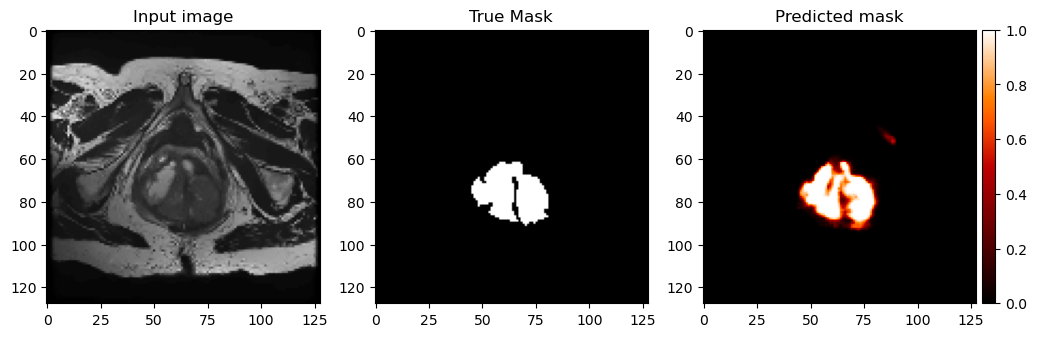

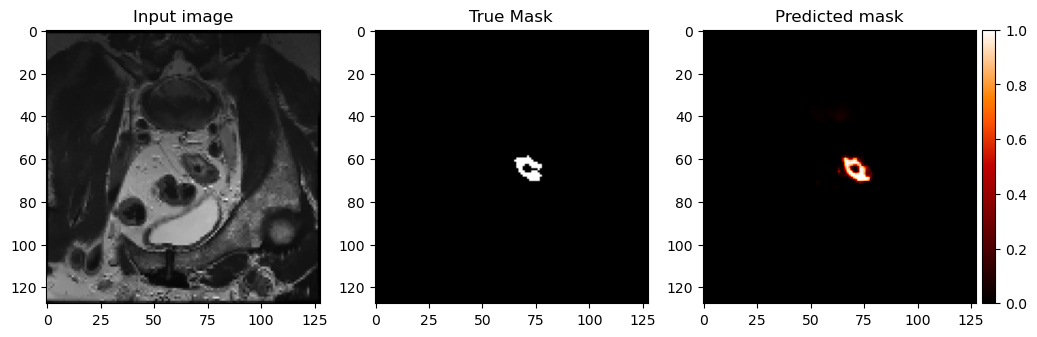

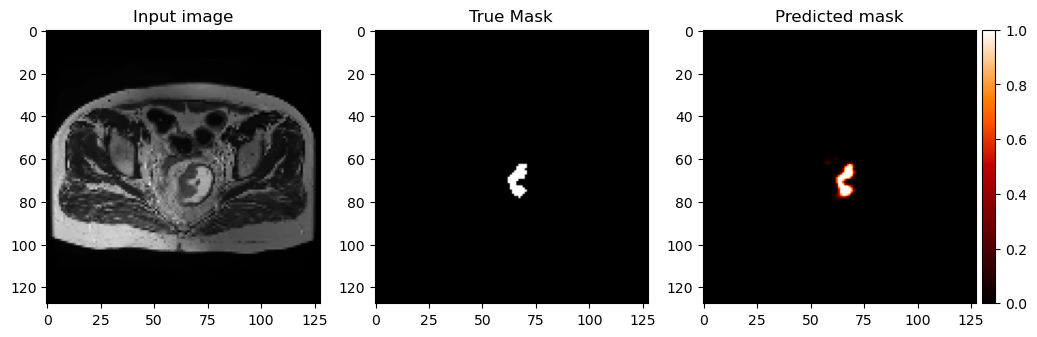

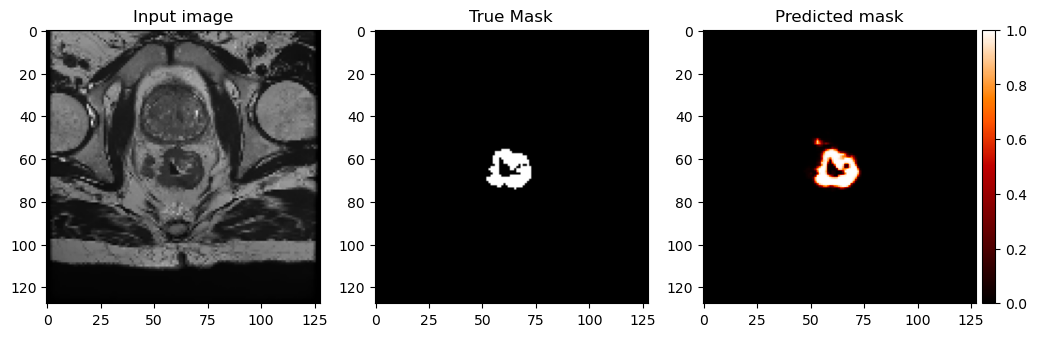

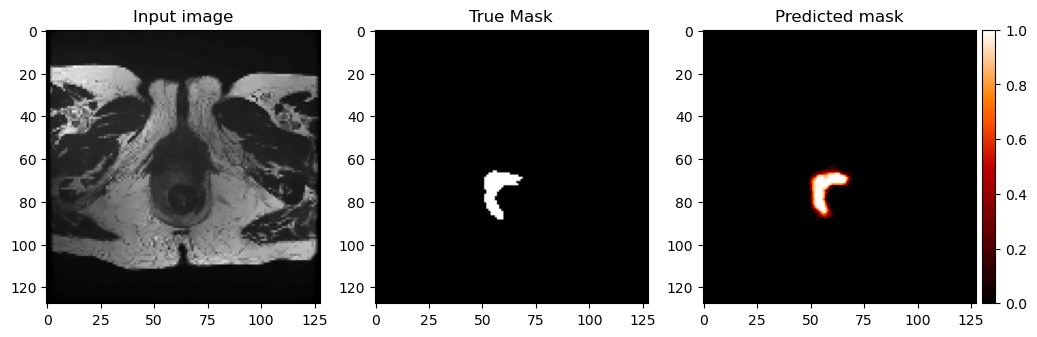

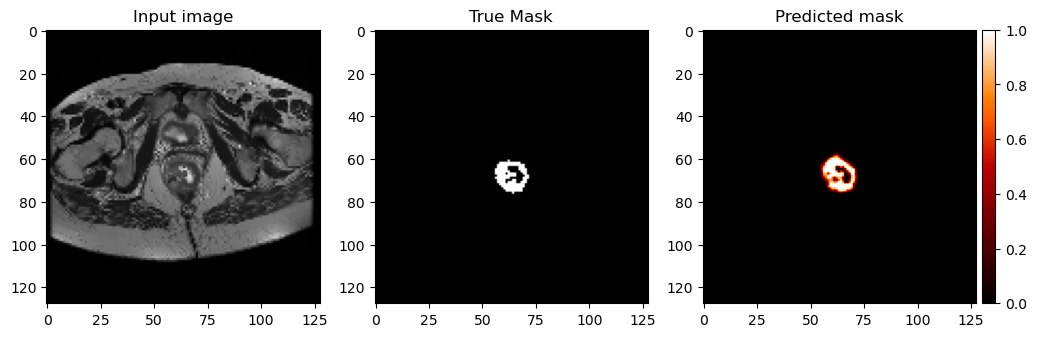

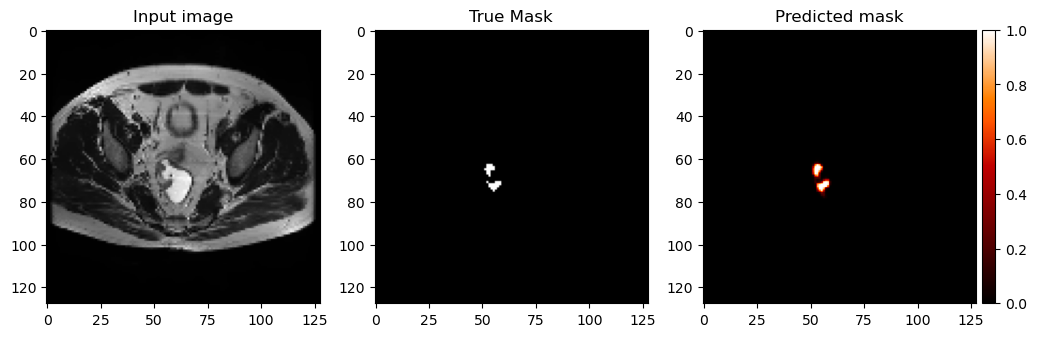

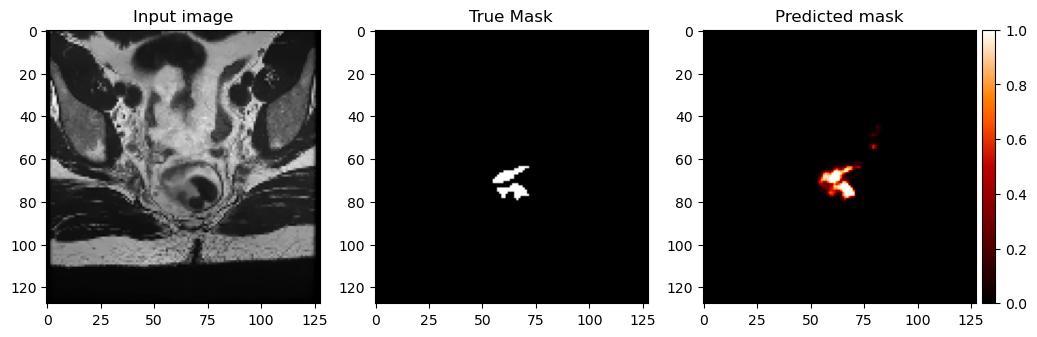

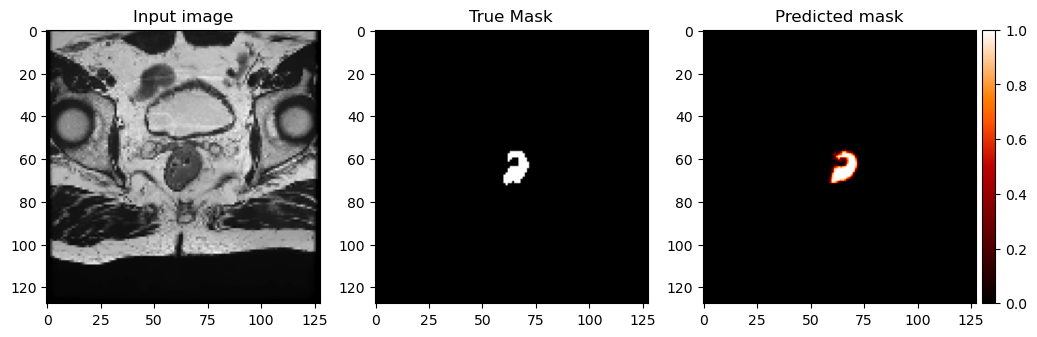

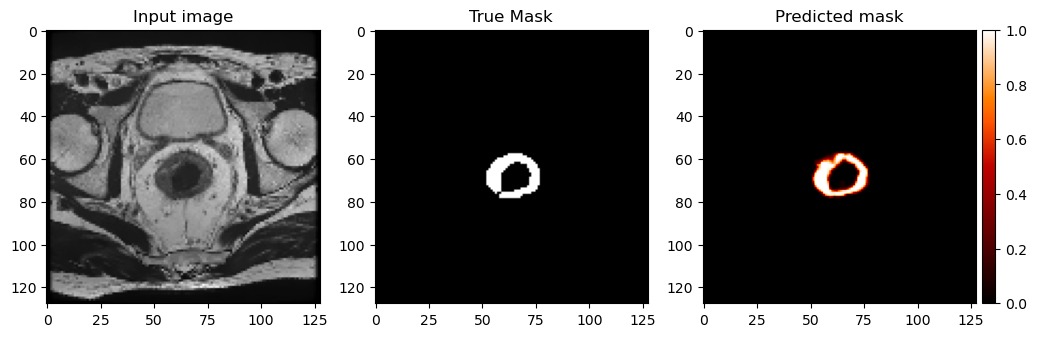

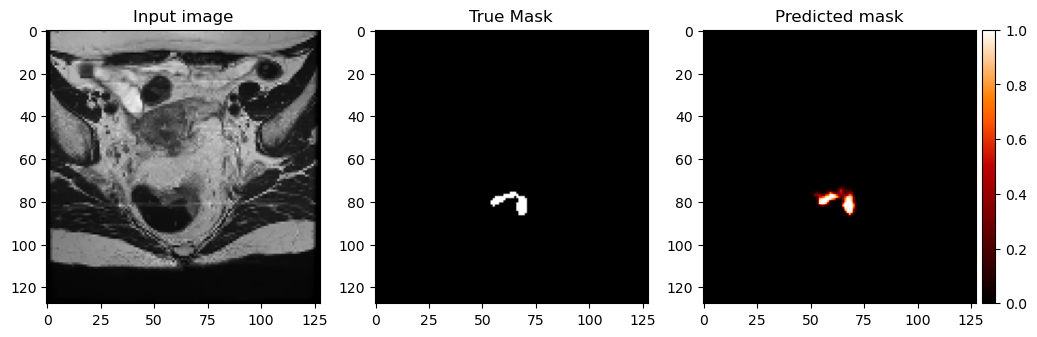

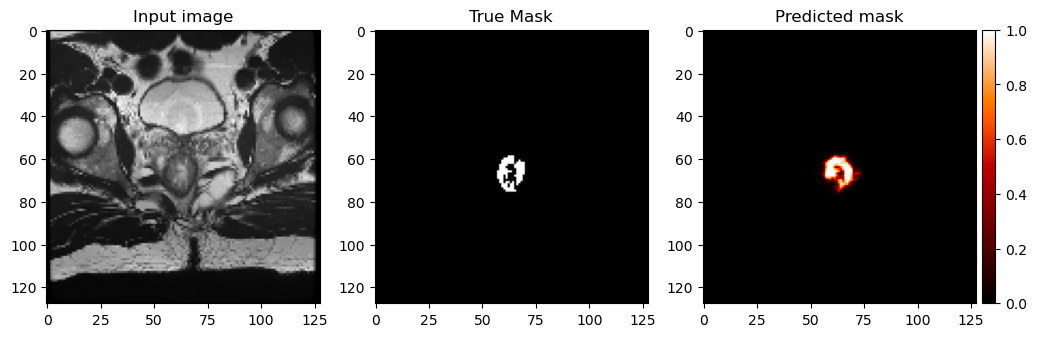

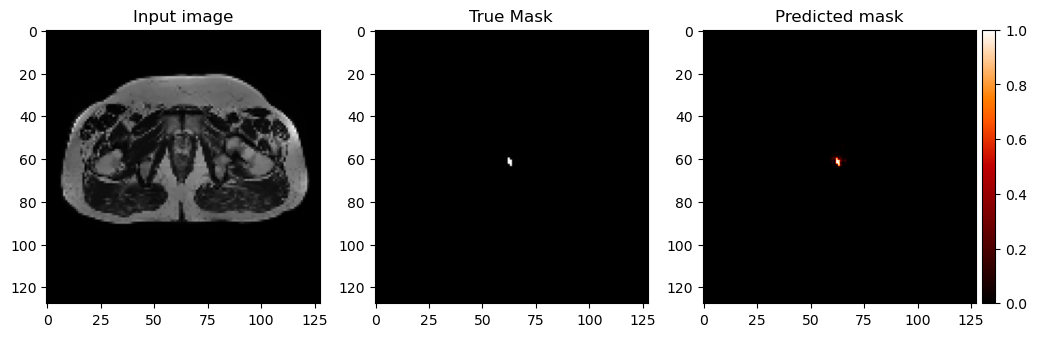

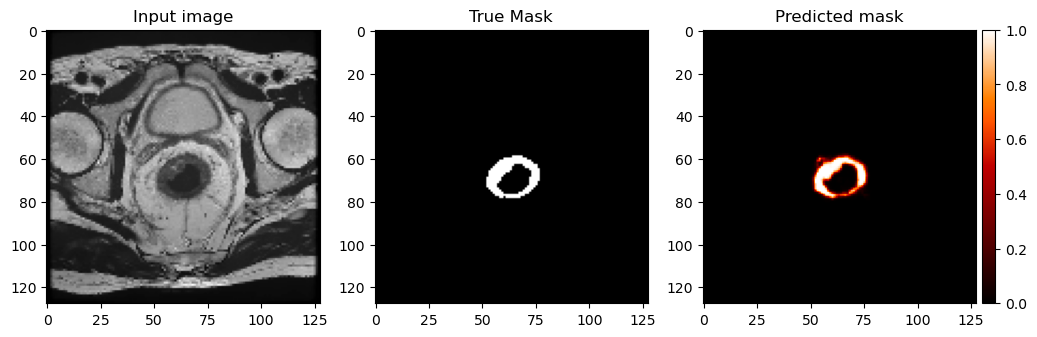

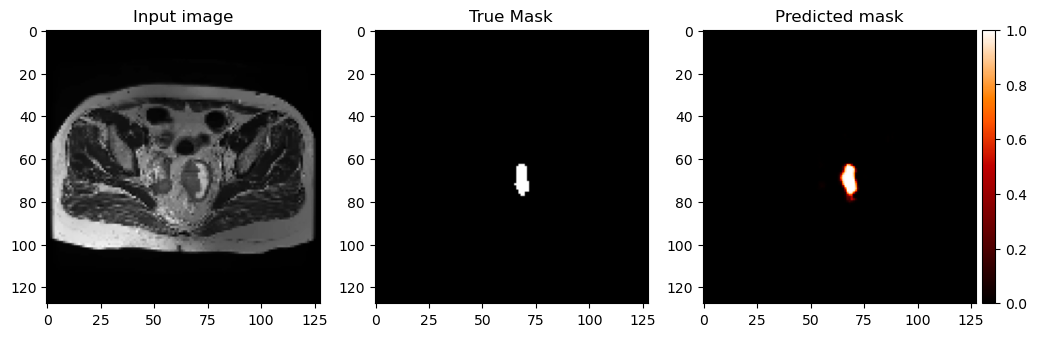

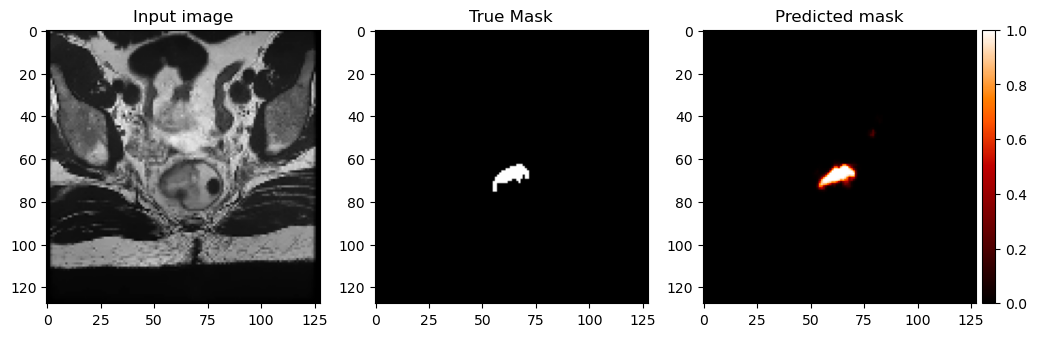

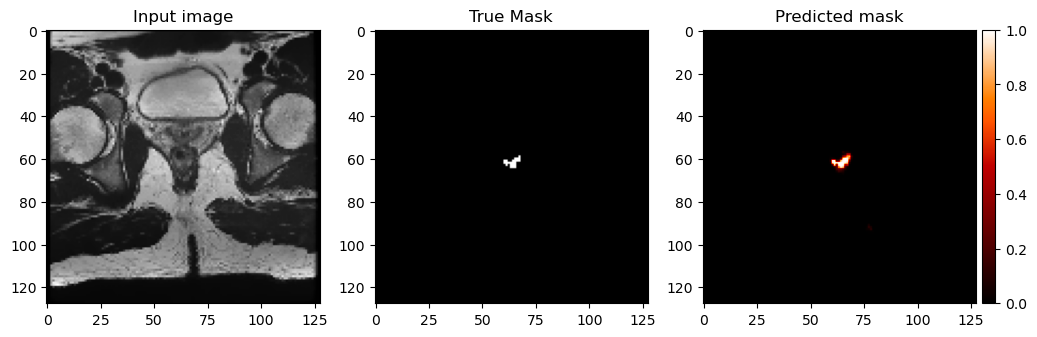

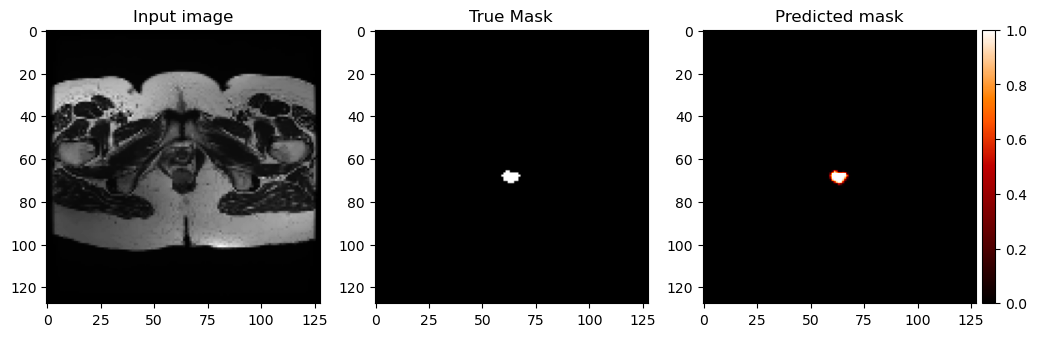

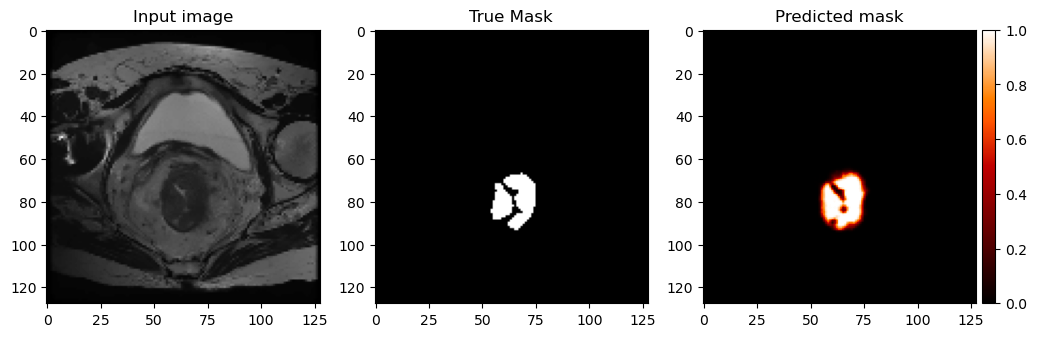

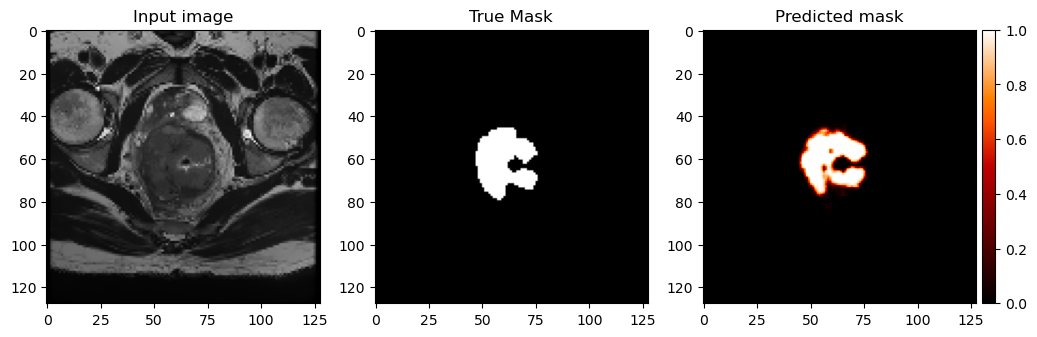

In [14]:
train_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, 1, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask) # val bc we want only rescaling

show_prediction(train_generator, model ,25)

### Validation images prediction

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.


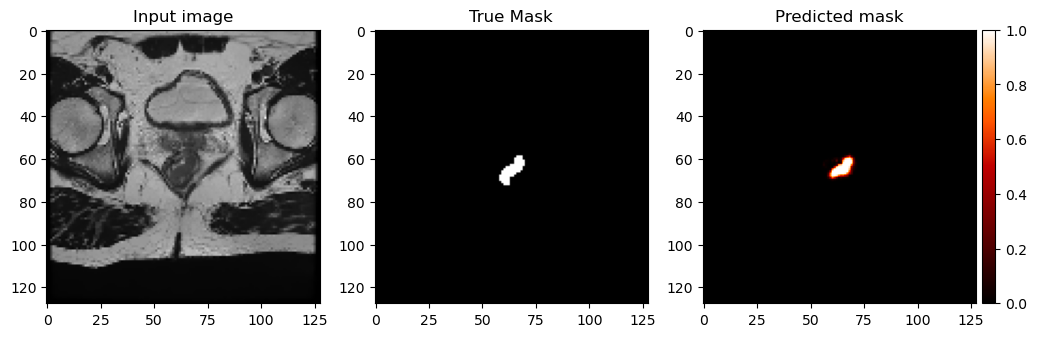

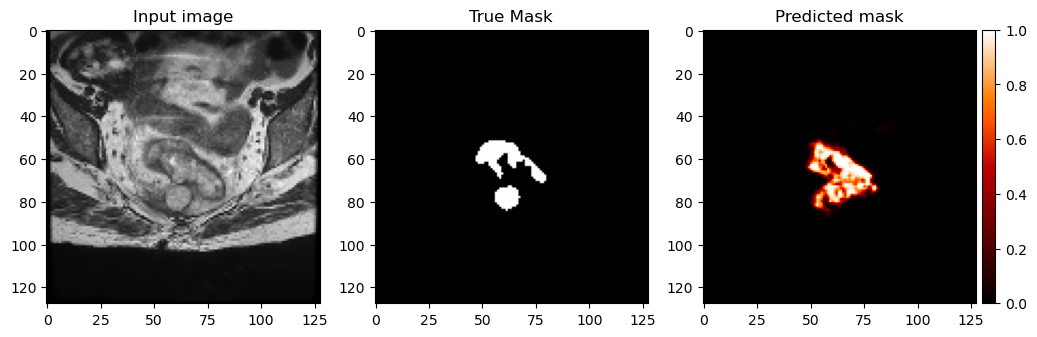

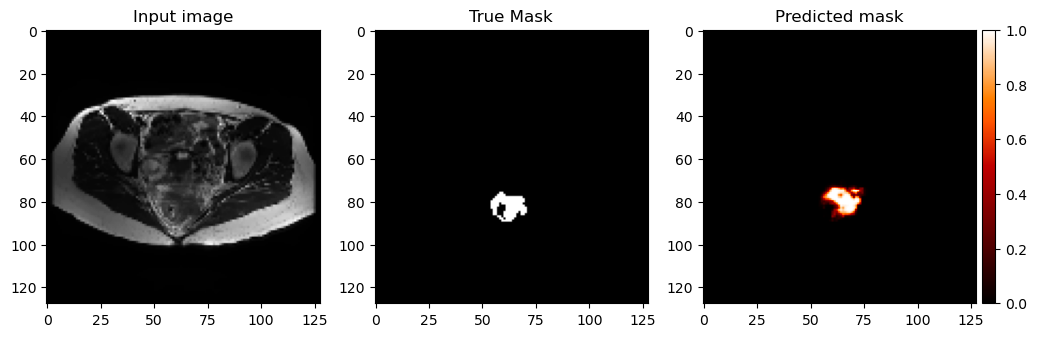

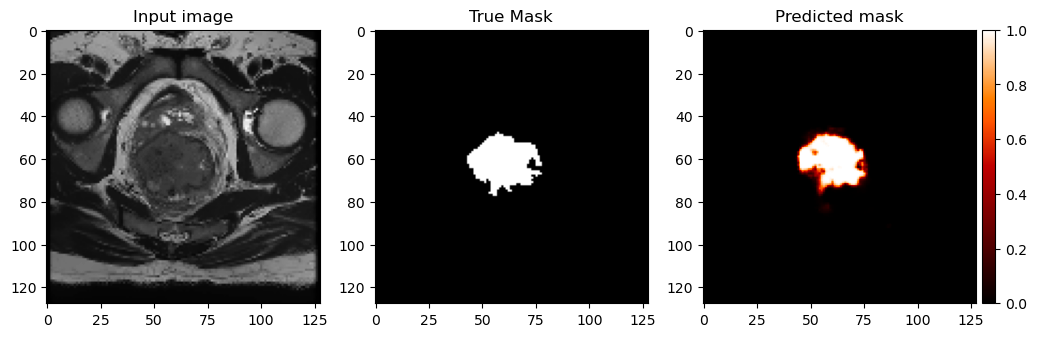

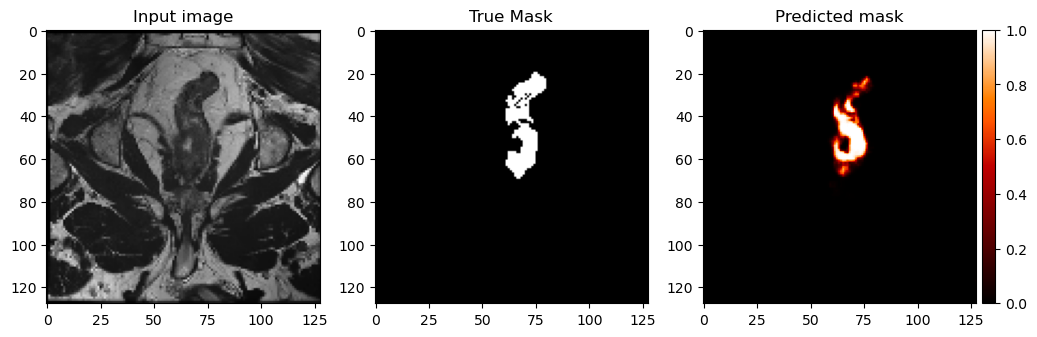

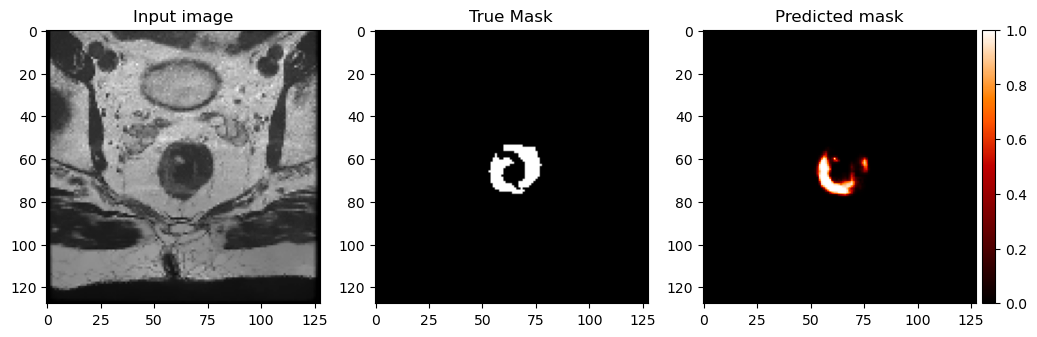

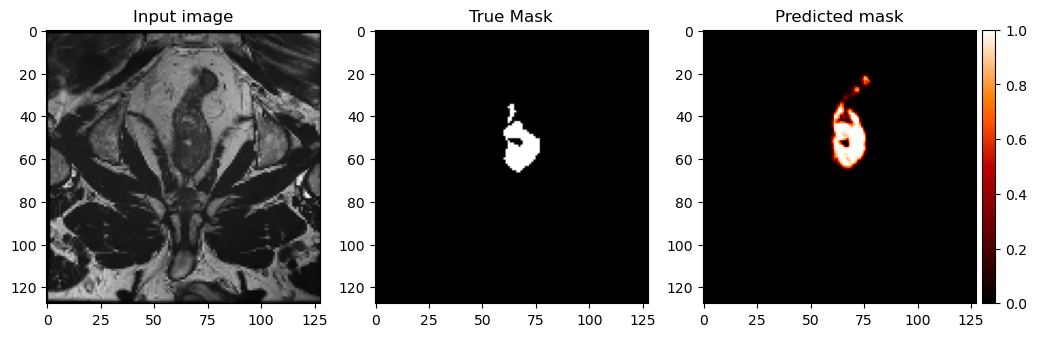

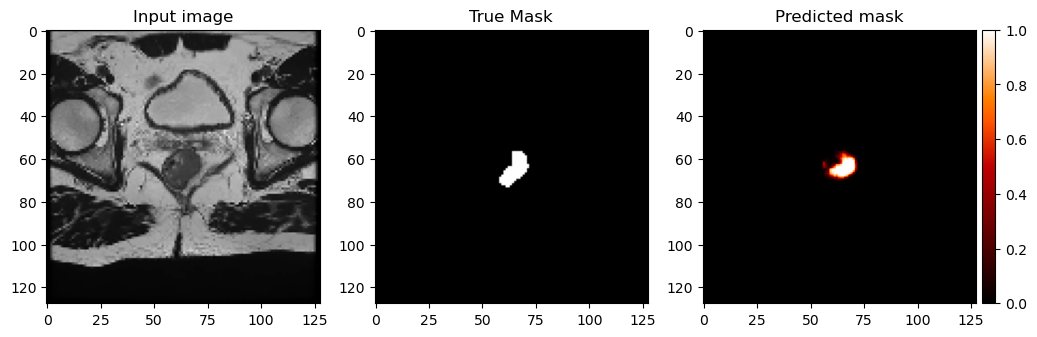

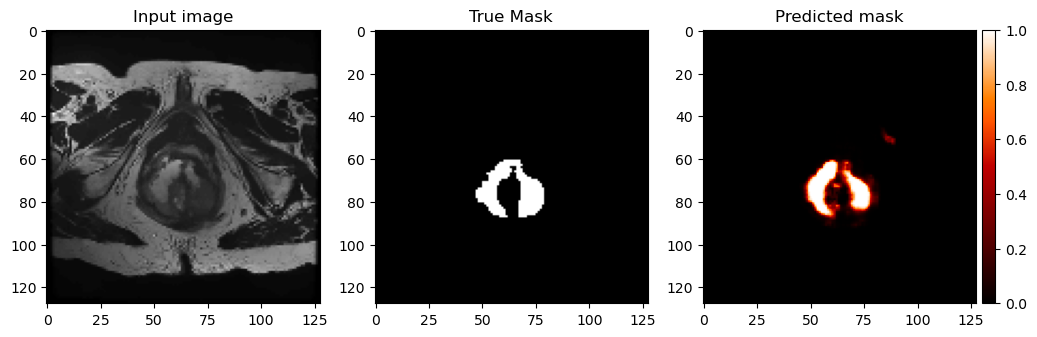

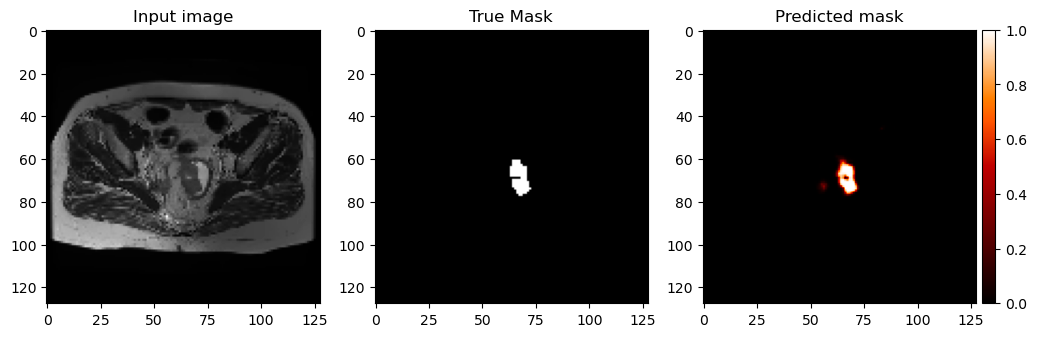

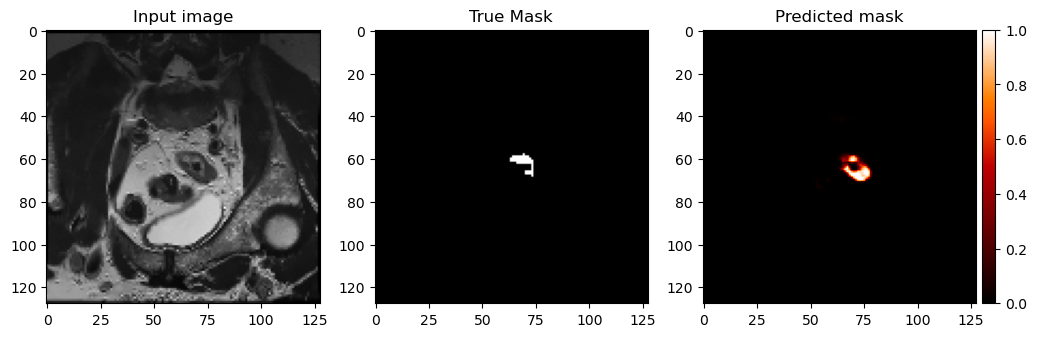

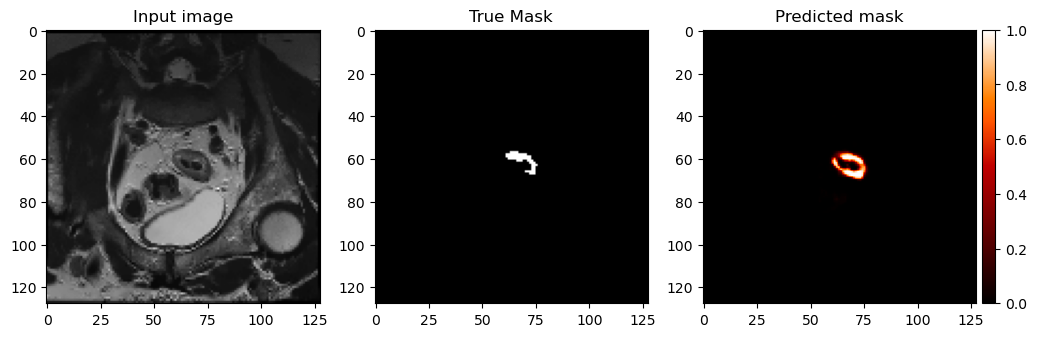

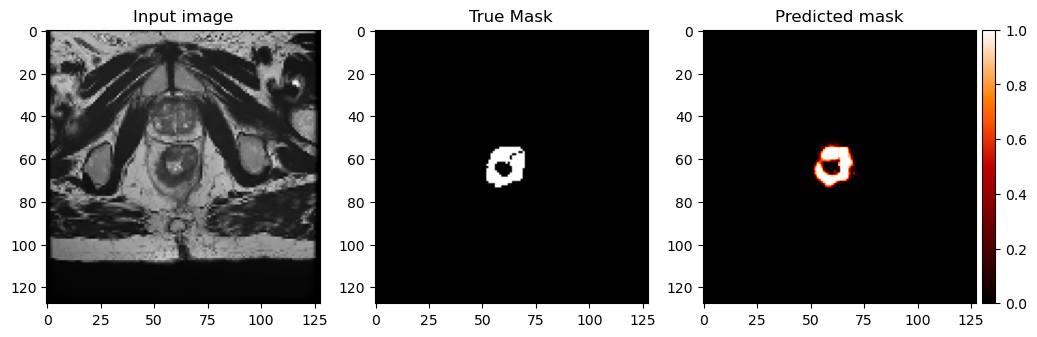

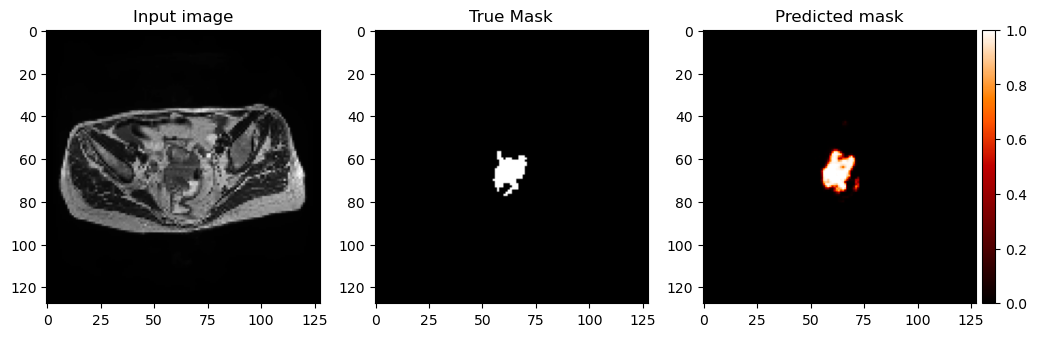

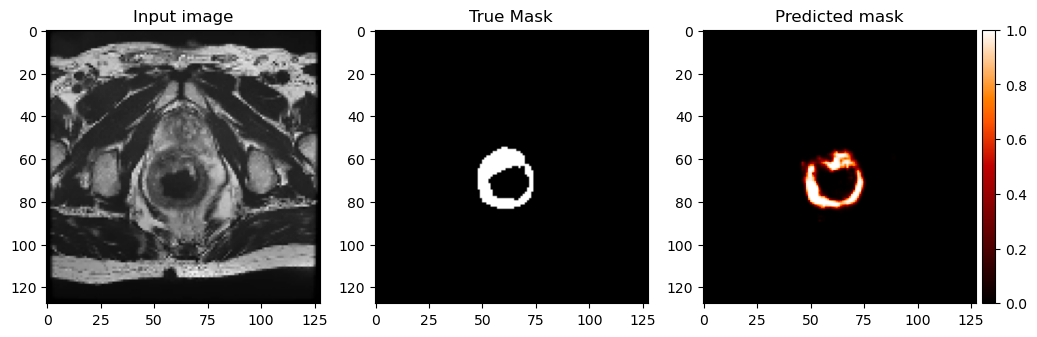

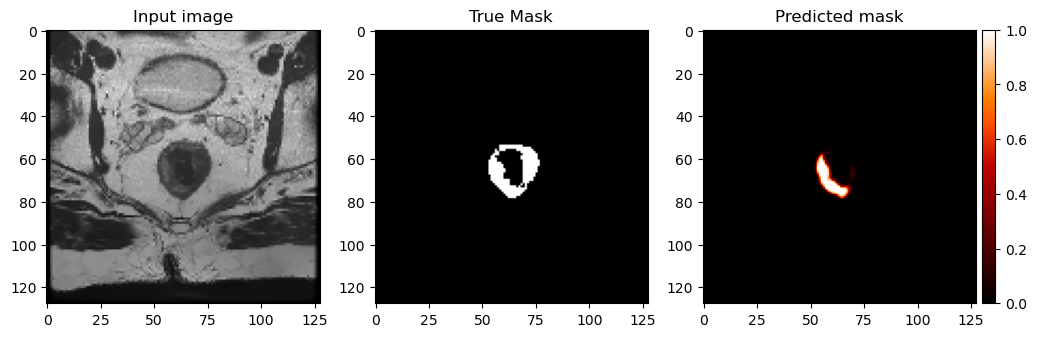

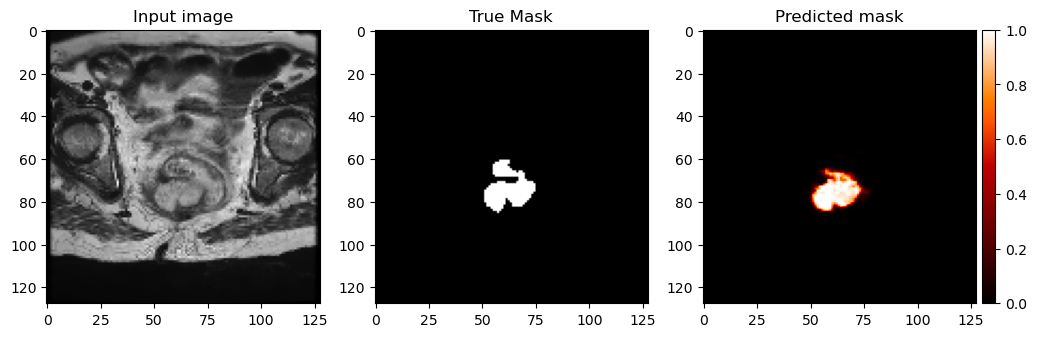

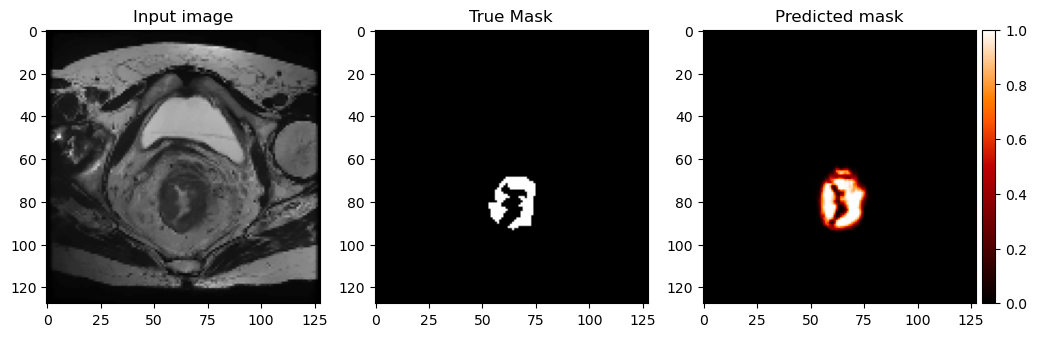

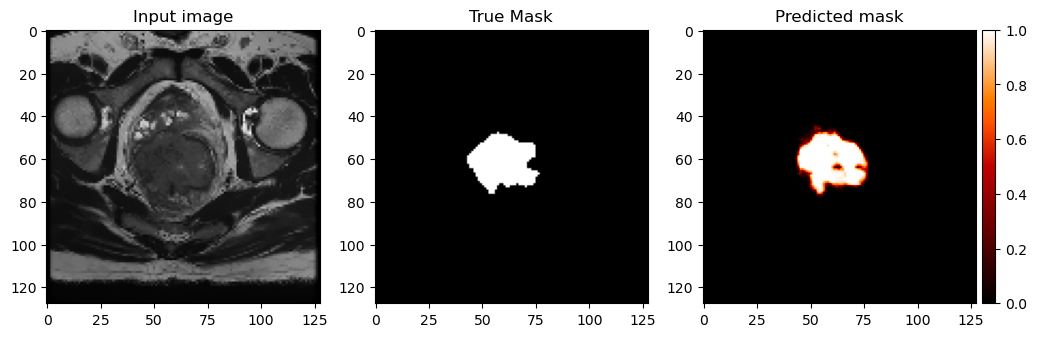

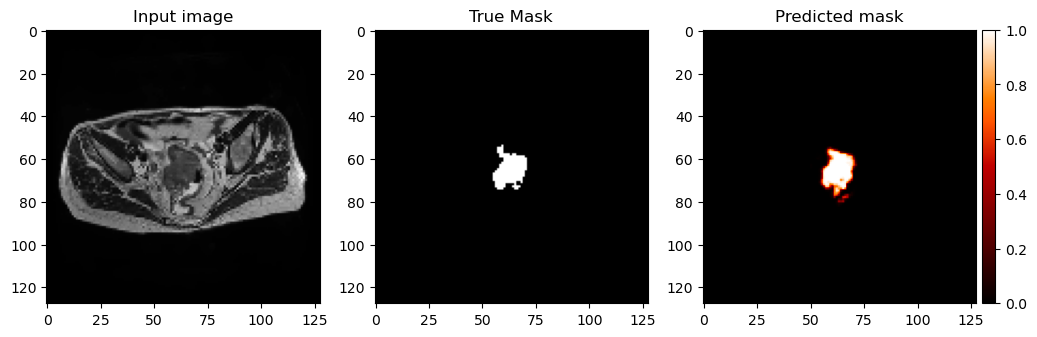

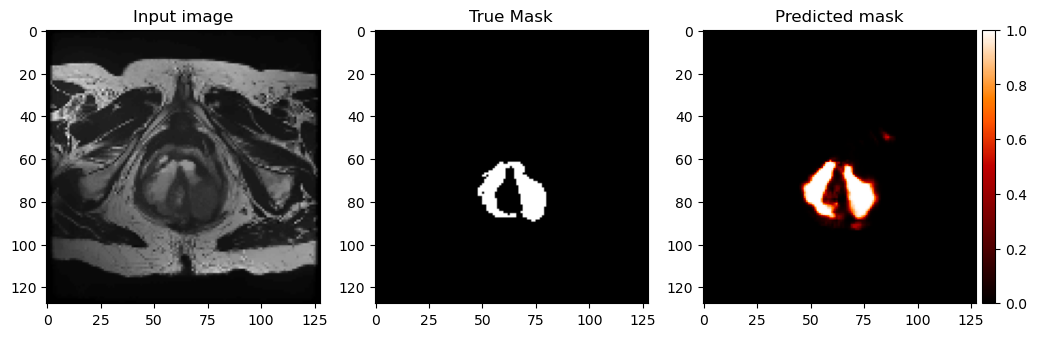

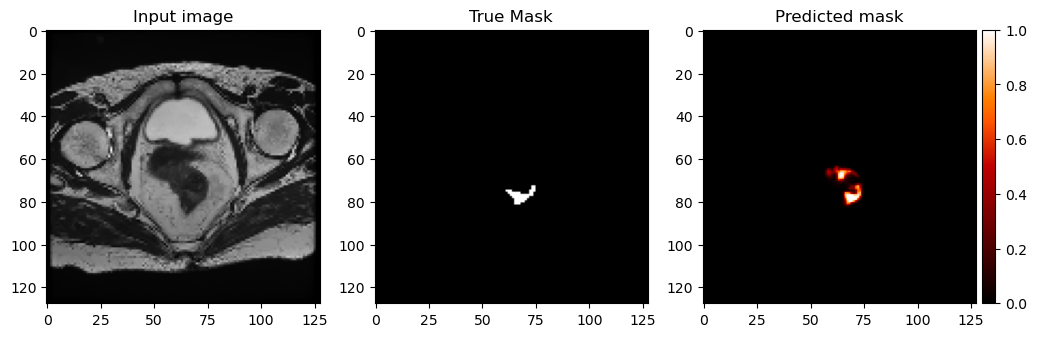

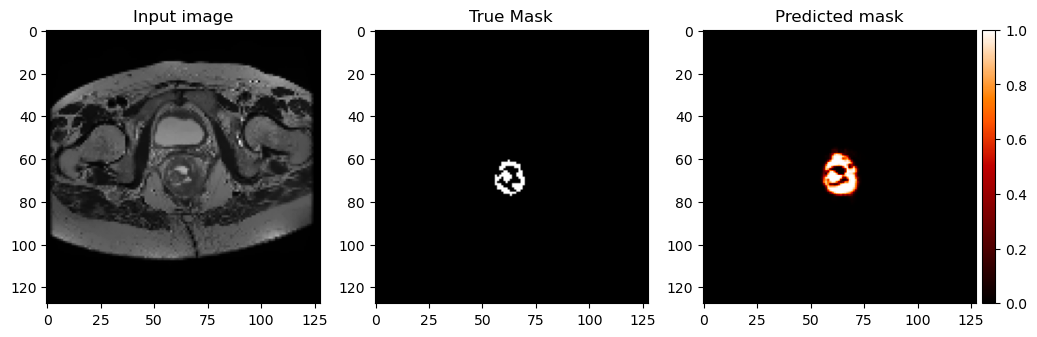

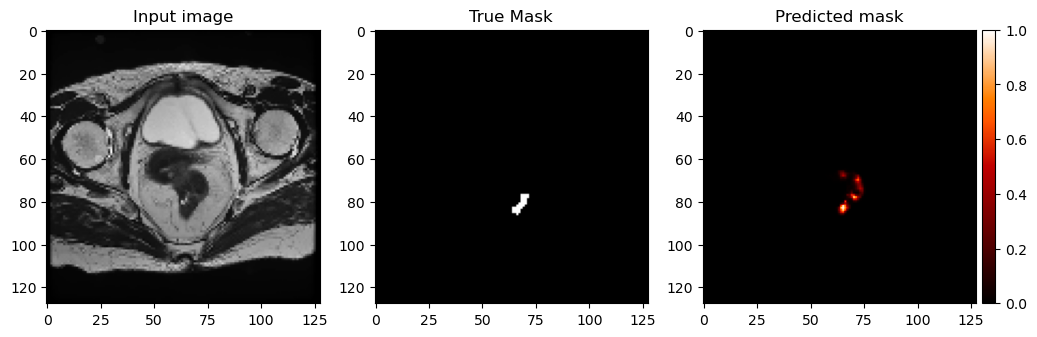

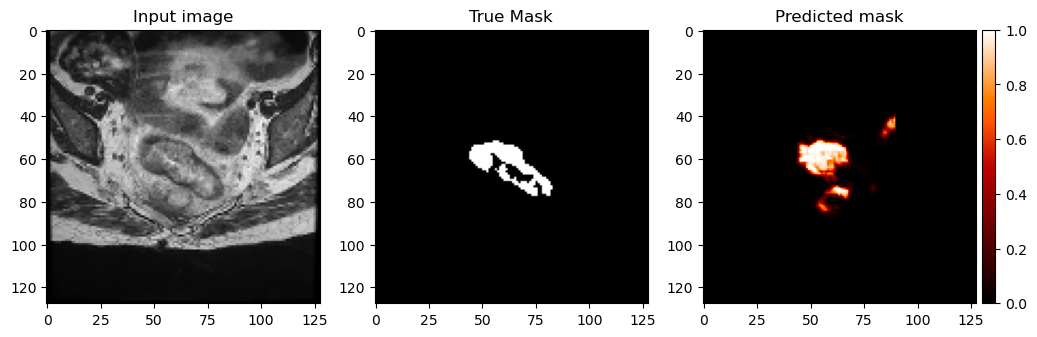

In [15]:
validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, 1, IMG_SIZE, SEED, val_data_gen_args_img, val_data_gen_args_mask)

show_prediction(validation_generator, model ,25)